In [0]:
# Importing Libraries

In [0]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

### Data

In [0]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [12]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [0]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [0]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [17]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

# Model having 1 LSTM layer with 32 LSTM Units

In [18]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history = model.fit(X_train, Y_train, batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 30s 4ms/step - loss: 1.3187 - acc: 0.4366 - val_loss: 1.1297 - va

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


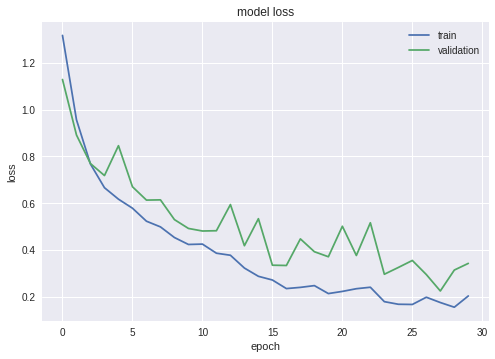

In [23]:
'''credits: https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy'''
import matplotlib.pyplot as plt
print(history.history.keys())

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

Test Score: 0.342137
Test Accuracy: 90.634544%


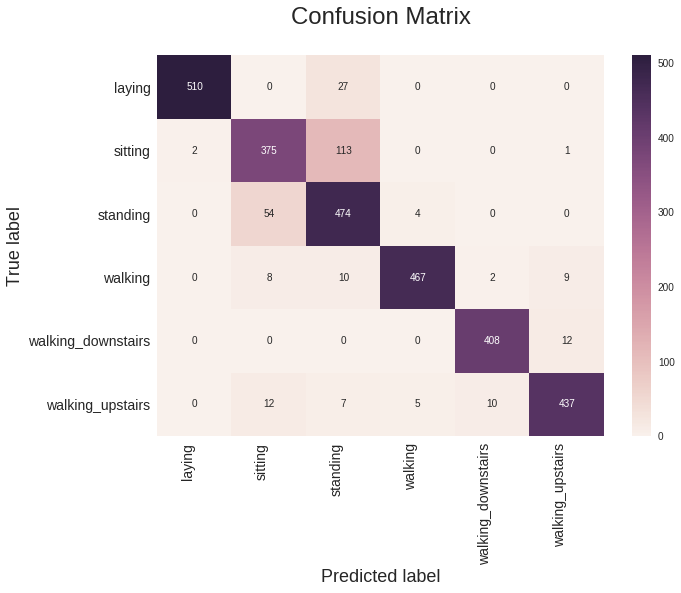

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores[0]))
print("Test Accuracy: %f%%" % (scores[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

### Observation:
- With a simple 2 layer architecture we got 90.63% accuracy and a loss of 0.34
- We can further imporve the performace with Hyperparameter tuning

# Model having 1 LSTM layer with 48 LSTM Units using 'adam' as an optimizer

In [25]:
# Initiliazing the sequential model
model1 = Sequential()
# Configuring the parameters
model1.add(LSTM(48, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model1.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model1.add(Dense(n_classes, activation='sigmoid'))
print(model1.summary())

# Compiling the model
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Training the model
history1 = model1.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 48)                11136     
_________________________________________________________________
dropout_2 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 294       
Total params: 11,430
Trainable params: 11,430
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 33s 4ms/step - loss: 1.3644 - acc: 0.3930 - val_loss: 1.2914 - val_acc: 0.4136
Epoch 2/30
7352/7352 [==============================] - 32s 4ms/step - loss: 1.2047 - acc: 0.4567 - val_loss: 1.2188 - val_acc: 0.4601
Epoch 3/30
7352/7352 [==============================] - 32s 4ms/step - loss: 1.

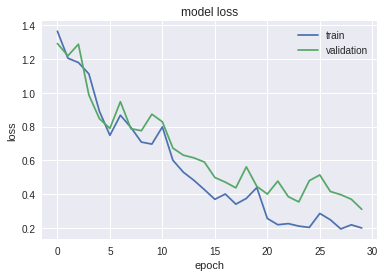

In [30]:
# "Loss"
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

Test Score: 0.309765
Test Accuracy: 89.379030%


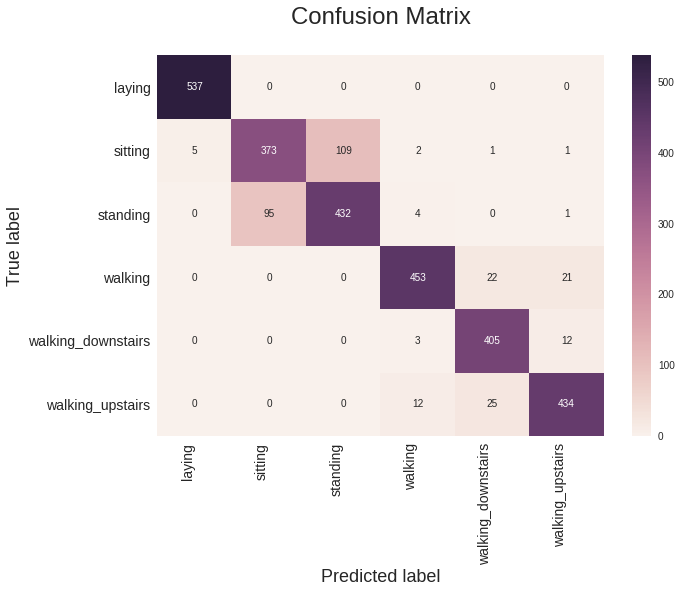

In [27]:
# Final evaluation of the model
scores1 = model1.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores1[0]))
print("Test Accuracy: %f%%" % (scores1[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model1.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# Model having 1 LSTM layer with 48 LSTM Units using 'rmsprop' as an optimizer

In [28]:
# Initiliazing the sequential model
model2 = Sequential()
# Configuring the parameters
model2.add(LSTM(48, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model2.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model2.add(Dense(n_classes, activation='sigmoid'))
print(model2.summary())

# Compiling the model
model2.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history2 = model2.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 48)                11136     
_________________________________________________________________
dropout_3 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 294       
Total params: 11,430
Trainable params: 11,430
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 33s 4ms/step - loss: 1.2254 - acc: 0.4827 - val_loss: 0.9652 - val_acc: 0.5959
Epoch 2/30
7352/7352 [==============================] - 32s 4ms/step - loss: 0.8471 - acc: 0.6255 - val_loss: 0.8372 - val_acc: 0.6261
Epoch 3/30
7352/7352 [==============================] - 32s 4ms/step - loss: 0.

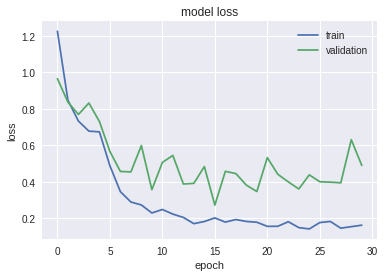

In [31]:
# "Loss"
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

Test Score: 0.489781
Test Accuracy: 89.175433%


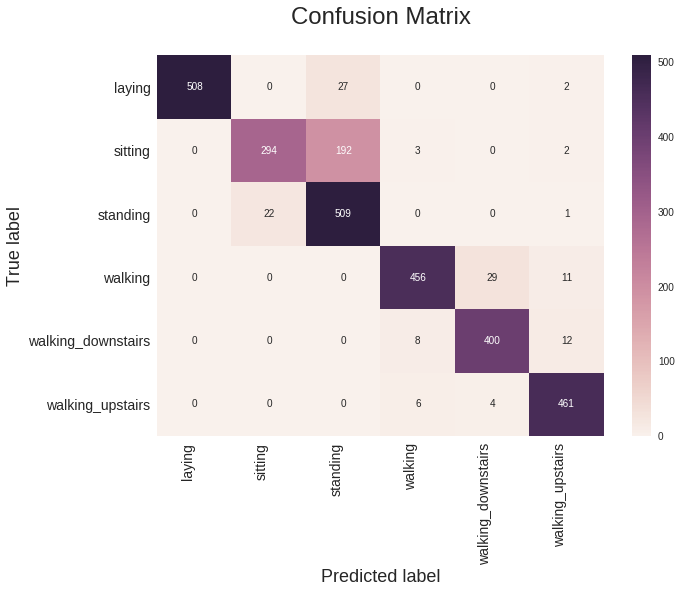

In [32]:
# Final evaluation of the model
scores2 = model2.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores2[0]))
print("Test Accuracy: %f%%" % (scores2[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model2.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# Model having 1 LSTM layer with 64 LSTM Units using 'rmsprop' as an optimizer

In [34]:
# Initiliazing the sequential model
model3 = Sequential()
# Configuring the parameters
model3.add(LSTM(64, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model3.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model3.add(Dense(n_classes, activation='sigmoid'))
print(model3.summary())

# Compiling the model
model3.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history3 = model3.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 37s 5ms/step - loss: 1.2560 - acc: 0.4506 - val_loss: 1.1102 - val_acc: 0.5667
Epoch 2/30
7352/7352 [==============================] - 36s 5ms/step - loss: 0.8985 - acc: 0.6182 - val_loss: 0.9145 - val_acc: 0.6729
Epoch 3/30
7352/7352 [==============================] - 36s 5ms/step - loss: 0.

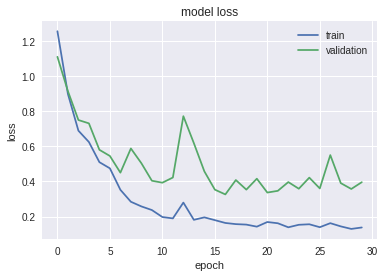

In [35]:
# "Loss"
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

Test Score: 0.395789
Test Accuracy: 90.770275%


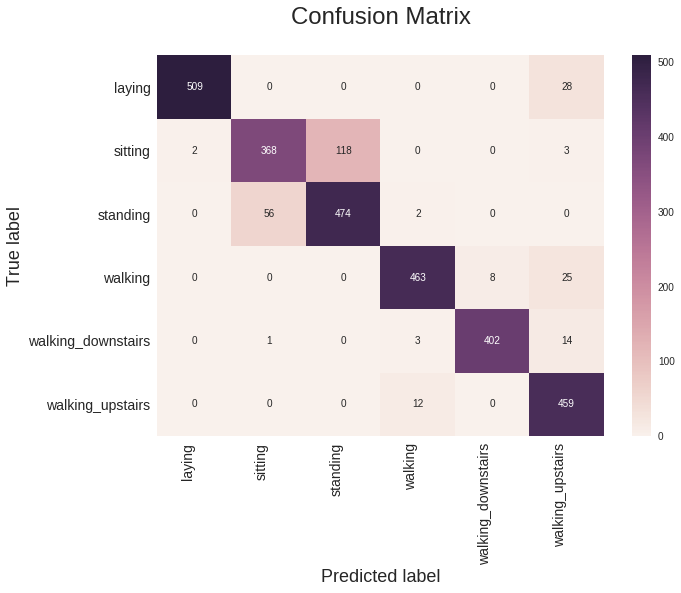

In [36]:
# Final evaluation of the model
scores3 = model3.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores3[0]))
print("Test Accuracy: %f%%" % (scores3[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model3.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# Model having 2 LSTM layers with 32 LSTM Units using 'rmsprop' as an optimizer

In [37]:
# Initiliazing the sequential model
model4 = Sequential()
# Configuring the parameters
model4.add(LSTM(32,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model4.add(Dropout(0.5))

# Configuring the parameters
model4.add(LSTM(32))
# Adding a dropout layer
model4.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model4.add(Dense(n_classes, activation='sigmoid'))
print(model4.summary())

# Compiling the model
model4.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history4 = model4.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 198       
Total params: 13,894
Trainable params: 13,894
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 64s 9ms/step - loss: 1.2257 -

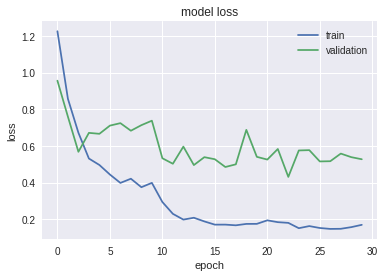

In [38]:
# "Loss"
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

Test Score: 0.526939
Test Accuracy: 90.464880%


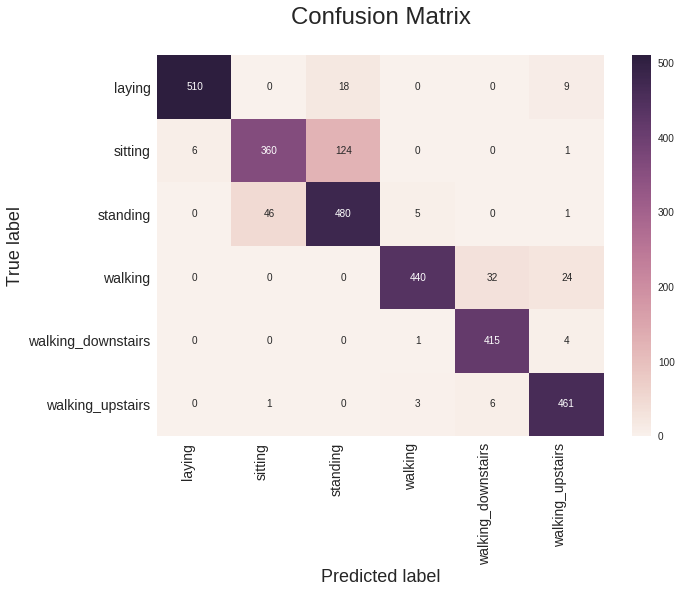

In [40]:
# Final evaluation of the model
scores4 = model4.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores4[0]))
print("Test Accuracy: %f%%" % (scores4[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model4.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# Model having 2 LSTM layers with 64 LSTM Units using 'rmsprop' as an optimizer

In [41]:
# Initiliazing the sequential model
model5 = Sequential()
# Configuring the parameters
model5.add(LSTM(64,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model5.add(Dropout(0.7))

# Configuring the parameters
model5.add(LSTM(64))
# Adding a dropout layer
model5.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model5.add(Dense(n_classes, activation='sigmoid'))
print(model5.summary())

# Compiling the model
model5.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history5 = model5.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
Total params: 52,358
Trainable params: 52,358
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 83s 11ms/step - loss: 1.1318 

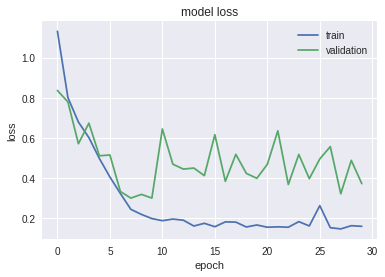

In [42]:
# "Loss"
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

Test Score: 0.370925
Test Accuracy: 90.804208%


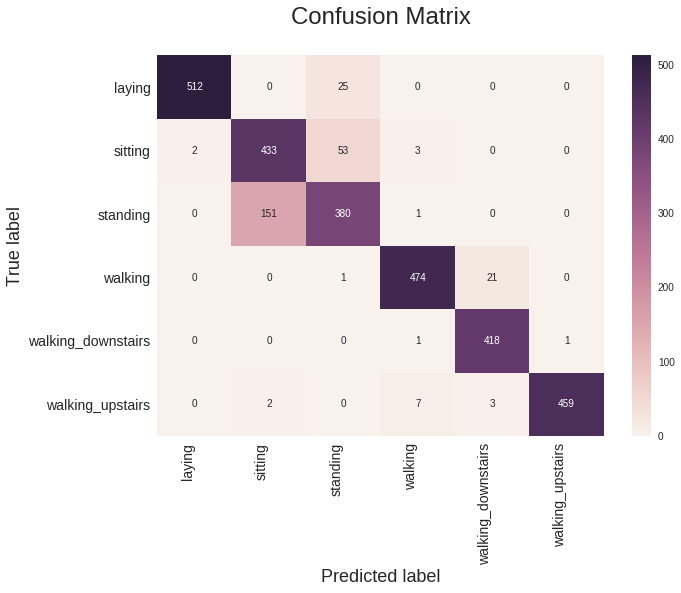

In [43]:
# Final evaluation of the model
scores5 = model5.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores5[0]))
print("Test Accuracy: %f%%" % (scores5[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model5.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# CONCLUSION

# Step by Step Procedure Followed :

1. Load the data and split into train and test data.
2. Tried different LSTM architectures and optimizers to see how the models perform.
3. Calculated the test score and accuracy for each of the model and printed in a neat table using prettytable.
4. Shown the confusion matrixces for each model.
5. In this case study, 2 LSTM with 64 LSTM units using rmsprop as an optimizer is giving the best accuracy.

# Table showing the Model performances:

In [44]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

# Names of models
names =['1 LSTM layer with 32 LSTM Units(Optimizer-->rmsprop)','1 LSTM layer with 48 LSTM Units(Optimizer-->adam)',\
        '1 LSTM layer with 48 LSTM Units(Optimizer-->rmsprop)','1 LSTM layer with 64 LSTM Units(Optimizer-->rmsprop)',\
        '2 LSTM layer with 32 LSTM Units(Optimizer-->rmsprop)','2 LSTM layer with 64 LSTM Units(Optimizer-->rmsprop)']

# Training accuracies
train_acc = [history.history['acc'][29],history1.history['acc'][29],history2.history['acc'][29],\
             history3.history['acc'][29],history4.history['acc'][29],history5.history['acc'][29]]

# Test accuracies
test_acc =[scores[1],scores1[1],scores2[1],scores3[1],scores4[1],scores5[1]]

numbering = [1,2,3,4,5,6]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)

# Printing the Table
print(ptable)

+-------+------------------------------------------------------+--------------------+--------------------+
| S.NO. |                        MODEL                         | Training Accuracy  |   Test Accuracy    |
+-------+------------------------------------------------------+--------------------+--------------------+
|   1   | 1 LSTM layer with 32 LSTM Units(Optimizer-->rmsprop) | 0.9377040261153428 | 0.9063454360366474 |
|   2   |  1 LSTM layer with 48 LSTM Units(Optimizer-->adam)   | 0.9275027203482046 | 0.8937902952154734 |
|   3   | 1 LSTM layer with 48 LSTM Units(Optimizer-->rmsprop) | 0.9495375408052231 | 0.8917543264336614 |
|   4   | 1 LSTM layer with 64 LSTM Units(Optimizer-->rmsprop) | 0.9494015233949945 | 0.9077027485578555 |
|   5   | 2 LSTM layer with 32 LSTM Units(Optimizer-->rmsprop) | 0.948177366702938  | 0.9046487953851374 |
|   6   | 2 LSTM layer with 64 LSTM Units(Optimizer-->rmsprop) | 0.9491294885745375 | 0.9080420766881574 |
+-------+----------------------------